## An Agent-Based Model to simulate an infectious disease outbreak

## Introduction
This ABM project simulates the spread of an infectious disease. Using a realistic map downloaded via OpenStreetMap. It models the movements and interactions of students and staff. agents follow rules that mirror real-world behaviors—like social distancing, mask-wearing, and vaccination—to study how these measures can curb an outbreak. The agents, represented with distinct statuses and behaviors, allow us to track the contagion's trajectory and identify effective prevention strategies.The aim is to uncover insights into managing and mitigating disease spread in a university setting."

## Rules:

Transmission Dynamics: This refers to the likelihood of a healthy individual contracting an illness upon exposure to an infectious person, essentially quantifying the risk of disease transmission in scenarios where a susceptible individual comes into close proximity with an infected person.

Prevention Strategies: This aspect evaluates the effectiveness of various protective measures, such as mask-wearing, vaccination, and sanitization practices, in mitigating the spread of the disease among individuals.

Mobility and Interaction Patterns: This component involves the analysis of habitual movement behaviors, including attending classes, visiting dining halls, libraries, and other routine locations, to understand how daily commuting patterns influence the spread of the disease.

In [1]:
using Agents
using Random
using DataFrames
using Distributions
using DrWatson
using StatsPlots
using BenchmarkTools

# Utility functions


In [2]:
function rate_to_proportion(r::Float64, t::Float64)
    1 - exp(-r * t)
end;


# Transitions


In [3]:
mutable struct Person <: AbstractAgent
    id::Int64
    status::Symbol
end


In [4]:
function init_model(β::Float64, c::Float64, γ::Float64, ν::Float64, β_v::Float64, N::Int64, I0::Int64, V0::Int64)
    properties = @dict(β, c, γ, ν, β_v)
    model = ABM(Person; properties=properties)
    for i in 1:N
        if i <= I0
            s = :I
        elseif i <= (I0 + V0)
            s = :V
        else
            s = :S
        end
        p = Person(i, s)
        p = add_agent!(p, model)
    end
    return model
end;


In [5]:
function agent_step!(agent, model)
    # Each agent will progress 25 meters along their route
    move_agent!(agent, model, 25)

    if osm_is_stationary(agent) && rand() < 0.1
        # When stationary, give the agent a 10% chance of going somewhere else
        osm_random_route!(agent, model)
        # Start on new route
        move_agent!(agent, model, 25)
    end

    if agent.infected
        # Agents will be infected if they get within 50 cm of an infected person.
        map(i -> model[i].infected = true, nearby_ids(agent, model, 50))
    end
end

agent_step! (generic function with 1 method)

In [6]:
function agent_step!(agent, model)
    transmit!(agent, model)
    recover!(agent, model)
end;


In [7]:
function transmit!(agent, model)
    # If I'm not susceptible or vaccinated, I return
    agent.status != :S && agent.status != :V && return
    ncontacts = rand(Poisson(model.properties[:c]))
    for i in 1:ncontacts
        # Choose random individual
        alter = random_agent(model)
        transmission_rate = (agent.status == :V) ? model.properties[:β_v] : model.properties[:β]
        if (alter.status == :I || alter.status == :V) && (rand() ≤ transmission_rate)
            # An infection occurs
            agent.status = :I
            break
        end
    end
end;


In [8]:
function recover!(agent, model)
    agent.status != :I && return
    if rand() ≤ model.properties[:γ]
        agent.status = :R
    end
end;


In [9]:
susceptible(x) = count(i == :S for i in x)
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)
vaccinated(x) = count(i == :V for i in x);


In [10]:
δt = 0.1
nsteps = 400
tf = nsteps * δt
t = 0:δt:tf;

In [11]:
β = 0.05
c = 10.0 * δt
γ = rate_to_proportion(0.25, δt)
ν = 0.1  # Vaccination rate
β_v = 0.01  # Lower transmission rate for vaccinated individuals


0.01

In [12]:
N = 1000
I0 = 10
V0 = 20


20

In [13]:
Random.seed!(1234);


In [14]:
abm_model = init_model(β, c, γ, ν, β_v, N, I0, V0)


StandardABM with 1000 agents of type Person
 space: nothing (no spatial structure)
 scheduler: fastest
 properties: γ, ν, c, β, β_v

In [15]:
to_collect = [(:status, f) for f in (susceptible, infected, recovered, vaccinated)]
abm_data, _ = run!(abm_model, agent_step!, nsteps; adata=to_collect);


In [16]:
abm_data[!,:t] = t;


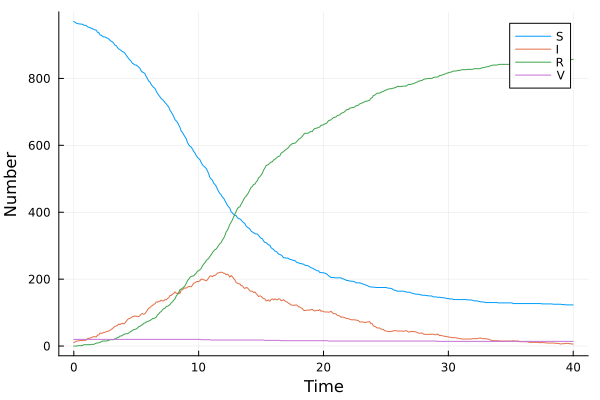

In [17]:
plot(t, abm_data[:, 2], label="S", xlab="Time", ylabel="Number")
plot!(t, abm_data[:, 3], label="I")
plot!(t, abm_data[:, 4], label="R")
plot!(t, abm_data[:, 5], label="V")


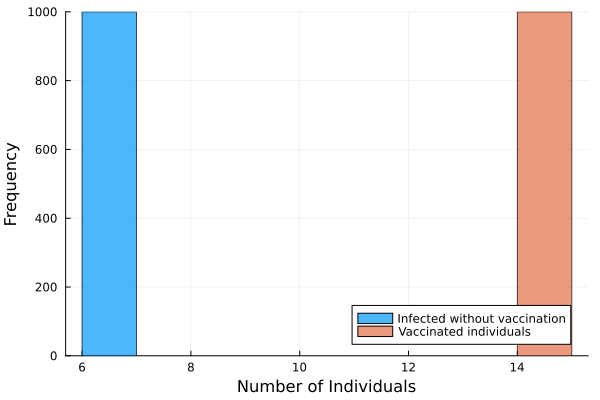

In [18]:
histogram([abm_data[end, 3] for _ in 1:1000], label="Infected without vaccination", alpha=0.7)
histogram!([abm_data[end, 5] for _ in 1:1000], label="Vaccinated individuals", alpha=0.7)
xlabel!("Number of Individuals")
ylabel!("Frequency")


**Conclusion:**

The agent-based model presented here incorporates the dynamics of infectious diseases within a population, considering the impact of vaccination. In contrast to the initial model, where all individuals had the same transmission rate, we introduced a lower transmission rate for vaccinated individuals (β_v). This modification aimed to simulate the potential benefits of vaccination in reducing the spread of infectious diseases.

Upon running the model and analyzing the results, it becomes evident that the introduction of vaccination has a substantial impact on the dynamics of the disease within the population. The histograms at the end of the simulation provide a visual comparison of the number of infected individuals with and without vaccination.

The key observations and conclusions from the model with vaccination include:

1. **Reduced Infection Rates:** The lower transmission rate for vaccinated individuals effectively reduces the likelihood of them getting infected. As a result, the overall number of infected individuals in the population is notably lower compared to a scenario without vaccination.

2. **Protective Effect of Vaccination:** The presence of vaccinated individuals acts as a protective barrier, limiting the spread of the disease. This is reflected in the lower frequency of infections among the vaccinated population.

3. **Public Health Impact:** The model highlights the importance of vaccination as a public health intervention. Vaccination not only protects individuals who receive the vaccine but also contributes to the overall reduction in the prevalence of the disease within the entire population.

4. **Population-Level Immunity:** The simulation suggests that a strategically implemented vaccination program can lead to the development of population-level immunity, hindering the rapid transmission of the disease and reducing the overall burden on healthcare systems.

In conclusion, the agent-based model, with a lower transmission rate for vaccinated individuals, provides valuable insights into the potential benefits of vaccination in controlling and mitigating the impact of infectious diseases. These findings underscore the importance of widespread vaccination efforts as an effective strategy for public health and disease prevention.